In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from particle_system import ParticleSystem
from calculate_coefficiens import calculate_forces
import matplotlib
from tqdm import tqdm
from IPython.display import HTML


def calc_mass(r, pho):
    return 4*np.pi*r**3*pho/3

n_particles = 3
l_max = 2
wl = 600
initial_positions = np.array([[0, 100, 100], [60, 50, 100], [150, 160, 100]])*1e-9
radii = (np.array([20,40,60])*1e-9).tolist()
#for Si particle
n = 3.9400 + 1j*0.019934
#in kg/m^3
rho = 2330
masses = np.array([ calc_mass(r, rho) for r in radii ])
initial_velocities = np.zeros((n_particles, 3))

#TODO create piecewise continuous random force before adding to solve_ivp
def forces(particle_system, t):
    force = calculate_forces(particle_system, t)
    random_force = particle_system.random_forces(particle_system.positions)
    force += random_force
    return force

# Create a particle system
particle_system = ParticleSystem(initial_positions, masses, forces, radii, l_max, wl, n)

# Flatten the initial state vector (positions and velocities)
y0 = np.concatenate((initial_positions, initial_velocities)).flatten()

t_span = (0, 1)
t_eval = np.linspace(t_span[0], t_span[1], 10)
result = particle_system.simulate(t_span, y0, t_eval)
print('Solving Done')
positions = result.y[:n_particles * 3].reshape((n_particles, 3, -1)) *1e9 # Reshape to (n_particles, 3, n_time_steps)
# Setup maximum bounds for the plot
max_x, max_y, max_z = np.max(positions, axis=(0, 2))
min_x, min_y, min_z = np.min(positions, axis=(0, 2))
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, n_particles))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_zlim(min_z, max_z)

def update(frame):
    ax.cla()
    ax.set_xlabel('X, nm')
    ax.set_ylabel('Y, nm')
    ax.set_zlabel('Z, nm')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_zlim(min_z, max_z)
    for i in range(n_particles):
        ax.plot(positions[i, 0, :frame],
        positions[i, 1, :frame],
        positions[i, 2, :frame],
        label=f'Particle {i+1}',
        color=colors[i])
        # Set markers on the last position
        ax.scatter(positions[i, 0, frame-1],
        positions[i, 1, frame-1],
        positions[i, 2, frame-1],
        color=colors[i])

        if frame > 1:
            arrow_indices = np.linspace(0, frame - 1, num=10, dtype=int)
            ax.quiver(positions[i, 0, arrow_indices[:-1]],
            positions[i, 1, arrow_indices[:-1]],
            positions[i, 2, arrow_indices[:-1]],
            positions[i, 0, arrow_indices[1:]] - positions[i, 0, arrow_indices[:-1]],
            positions[i, 1, arrow_indices[1:]] - positions[i, 1, arrow_indices[:-1]],
            positions[i, 2, arrow_indices[1:]] - positions[i, 2, arrow_indices[:-1]],
            length=0.2, normalize=True, color='r', arrow_length_ratio=0.4, linewidth=2)
    ax.legend()

ani = FuncAnimation(fig, update, frames=tqdm(range(len(t_eval))), repeat=False)
ani.save('particle_motion.gif', writer='pillow', fps=10, dpi=100)

# Show animation with buttons for controls
HTML(ani.to_jshtml())

KeyboardInterrupt: 

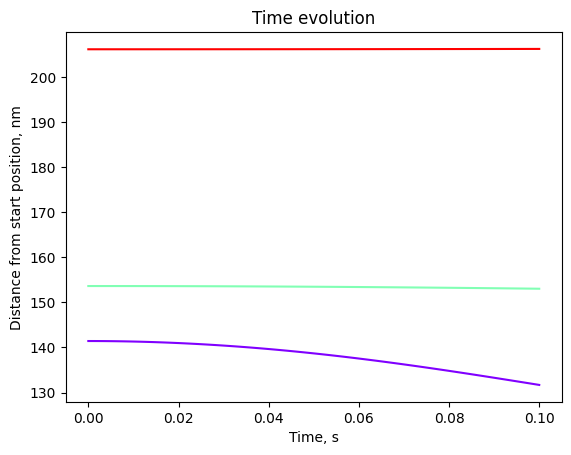

In [4]:
# Plotting length of radius vector for each particle
fig, ax = plt.subplots()
ax.set_xlabel('Time, s')
ax.set_ylabel('Distance from start position, nm')
ax.set_title("Time evolution")
for i in range(n_particles):
    r = np.linalg.norm(positions[i] - np.tile(initial_positions[i], (len(t_eval), 1)).T, axis=0)
    ax.plot(t_eval, r, label=f'Particle {i+1}', color=colors[i])
plt.show()    